In [6]:
%cd .. 

/home/d/PycharmProjects/protein_properties


In [1]:
# For automatic file reloading as usual
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from src.data.lightning_sasa import SASADataConfig, SASADataModule, SASADataset
from src.models import SASABaseline
import pandas as pd
import os 
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
import torch
from torch.utils.data import DataLoader, RandomSampler, Subset
from tqdm import tqdm

### Debug 2 class baseline

In [3]:
config = SASADataConfig(data_dir="data/sasa", embedding_path="data/sasa/sasaembeddings.h5", num_workers=4, num_classes=2, np_path="data/sasa/")
data_module = SASADataModule(config=config)
data_module.setup("fit")

Data preparation already done!


In [6]:
for i, b in enumerate(data_module.train_dataloader()):
    print(b[0].shape)
    break

torch.Size([1, 316, 1024])


In [7]:
# Plot distribution of residues per accumlated batch
res_per_batch = []
accumulated_batches = 32
for i in range(100):
    batch = 0
    for i, b in enumerate(data_module.train_dataloader()):
        batch += (b[0].shape[1])
        if i % accumulated_batches == 0 or i == len(data_module.train_dataloader()) - 1:
            res_per_batch.append(batch)
            batch = 0

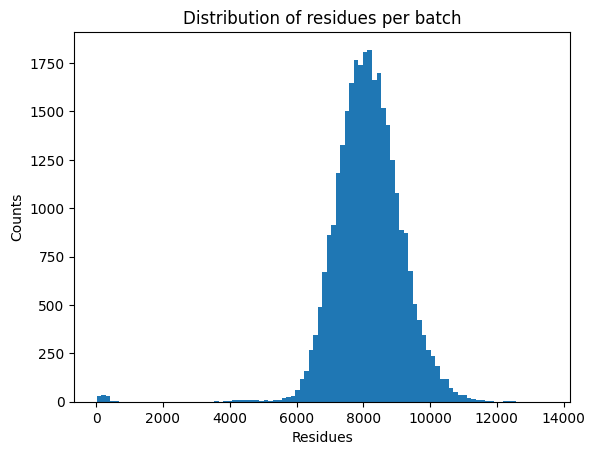

In [10]:
# Plot distribution of residues per accumlated batch
plt.hist(res_per_batch, bins=100)
plt.title("Distribution of residues per batch")
plt.xlabel("Residues")
plt.ylabel("Counts")
plt.show()

In [38]:
logger = CSVLogger("logs", name="debug_model")
one_sample_train_set = DataLoader(Subset(data_module.train_dataset, [42]), batch_size=1, shuffle=False, num_workers=4)
one_samples_trainer = pl.Trainer(accelerator="gpu", detect_anomaly=True ,limit_val_batches=0.3 ,devices=1,precision="16-mixed",deterministic=True, max_epochs=100, enable_checkpointing=False, limit_train_batches=1, logger=logger)
model = SASABaseline(config.num_classes)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.


In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/ 

In [ ]:
one_samples_trainer.fit(model, one_sample_train_set, data_module.validation_dataloader())

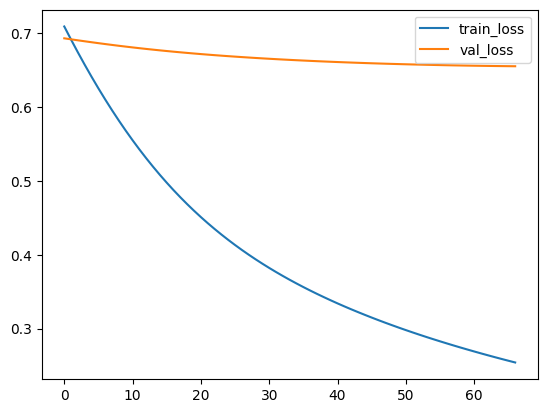

In [40]:
plt.plot(pd.read_csv("logs/debug_model/version_0/metrics.csv")["train_loss_epoch"].dropna().reset_index(drop=True), label="train_loss")
plt.plot(pd.read_csv("logs/debug_model/version_0/metrics.csv")["val_loss"].dropna().reset_index(drop=True), label="val_loss")
plt.legend()
plt.show()


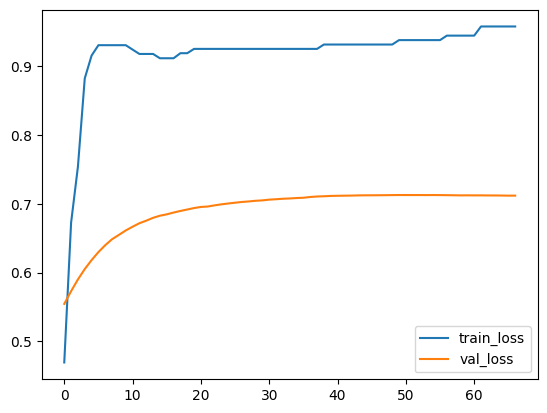

In [41]:
plt.plot(pd.read_csv("logs/debug_model/version_0/metrics.csv")["train_F1_epoch"].dropna().reset_index(drop=True), label="train_loss")
plt.plot(pd.read_csv("logs/debug_model/version_0/metrics.csv")["val_F1"].dropna().reset_index(drop=True), label="val_loss")
plt.legend()
plt.show()


### Now try some more samples

In [48]:
logger = CSVLogger("logs", name="one_sample")
one_sample_train_set = DataLoader(Subset(data_module.train_dataset, torch.arange(42)), batch_size=1, shuffle=True, num_workers=4)
one_samples_trainer = pl.Trainer(accelerator="gpu", devices=1, detect_anomaly=True ,limit_val_batches=0.3, precision="16-mixed",deterministic=True, max_epochs=200, enable_checkpointing=False, accumulate_grad_batches=10, logger=logger)
model = SASABaseline(config.num_classes)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [49]:
one_samples_trainer.fit(model, one_sample_train_set, data_module.validation_dataloader())

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


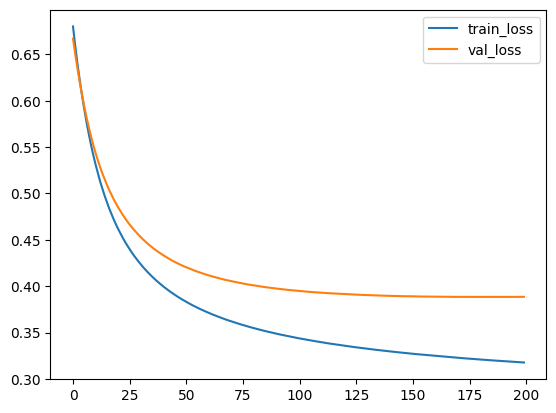

In [50]:
plt.plot(pd.read_csv("logs/one_sample/version_0/metrics.csv")["train_loss_epoch"].dropna().reset_index(drop=True), label="train_loss")
plt.plot(pd.read_csv("logs/one_sample/version_0/metrics.csv")["val_loss"].dropna().reset_index(drop=True), label="val_loss")
plt.legend()
plt.show()

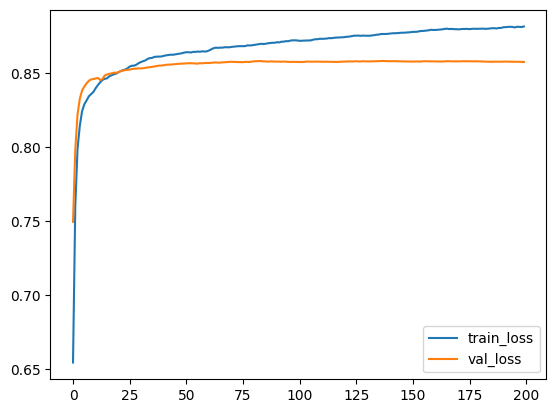

In [51]:
plt.plot(pd.read_csv("logs/one_sample/version_0/metrics.csv")["train_F1_epoch"].dropna().reset_index(drop=True), label="train_loss")
plt.plot(pd.read_csv("logs/one_sample/version_0/metrics.csv")["val_F1"].dropna().reset_index(drop=True), label="val_loss")
plt.legend()
plt.show()


### Debug 3 class baseline

In [3]:
config = SASADataConfig(data_dir="data/sasa", embedding_path="data/sasa/sasaembeddings.h5", num_workers=8, num_classes=3, np_path="data/sasa/")
data_module = SASADataModule(config=config)
data_module.setup("fit")

Data preparation already done!
Creating numpy arrays...


100%|██████████| 9715/9715 [00:37<00:00, 256.97it/s] 


Creating numpy arrays...


100%|██████████| 1080/1080 [00:00<00:00, 1419.45it/s]


Creating numpy arrays...


100%|██████████| 21/21 [00:00<00:00, 1190.94it/s]


In [6]:
logger = CSVLogger("logs", name="debug_model_3")
one_sample_train_set = DataLoader(Subset(data_module.train_dataset, [169]), batch_size=1, shuffle=False, num_workers=8)
one_samples_trainer = pl.Trainer(accelerator="gpu", detect_anomaly=True ,limit_val_batches=0.3 ,devices=1,precision="16-mixed",deterministic=True, max_epochs=100, enable_checkpointing=False, limit_train_batches=1, logger=logger)
model = SASABaseline(config.num_classes)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.


In [16]:
data_module.train_dataset[169]

(array([[ 0.1208   , -0.3125   , -0.11194  , ...,  0.07117  , -0.2615   ,
         -0.03918  ],
        [ 0.06116  , -0.0029   , -0.2042   , ...,  0.2634   , -0.1937   ,
         -0.2727   ],
        [ 0.155    , -0.05536  , -0.0368   , ...,  0.4456   , -0.212    ,
         -0.5166   ],
        ...,
        [-0.2444   , -0.0768   , -0.2625   , ...,  0.03018  , -0.0867   ,
         -0.11633  ],
        [-0.182    , -0.2455   , -0.00938  , ...,  0.0005617, -0.1599   ,
         -0.10754  ],
        [-0.03708  , -0.1965   , -0.1779   , ..., -0.0848   , -0.2052   ,
         -0.0859   ]], dtype=float16),
 array([2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2,
        2, 0, 2, 0, 2, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 2, 0, 2,
        2, 0, 1, 2, 2, 0, 2, 0, 1, 0, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 0, 1,
        0, 1, 0, 2, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 0, 2, 2, 1, 0, 2, 2, 1,
        1, 2, 2, 2, 2, 2]))

In [ ]:
one_samples_trainer.fit(model, one_sample_train_set, data_module.validation_dataloader())

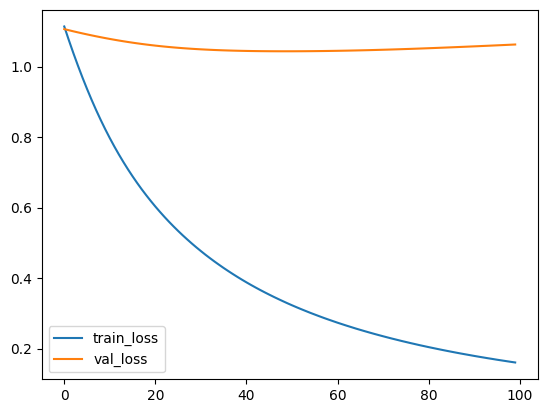

In [18]:
plt.plot(pd.read_csv("logs/debug_model_3/version_0/metrics.csv")["train_loss_epoch"].dropna().reset_index(drop=True), label="train_loss")
plt.plot(pd.read_csv("logs/debug_model_3/version_0/metrics.csv")["val_loss"].dropna().reset_index(drop=True), label="val_loss")
plt.legend()
plt.show()


### Debug 10 state Baseline

In [7]:
config = SASADataConfig(data_dir="data/sasa", embedding_path="data/sasa/sasaembeddings.h5", num_workers=4, num_classes=10, np_path="data/sasa/")
data_module = SASADataModule(config=config)
data_module.setup("fit")

Data preparation already done!
Creating numpy arrays...


100%|██████████| 9715/9715 [00:19<00:00, 490.12it/s]


Creating numpy arrays...


100%|██████████| 1080/1080 [00:02<00:00, 388.38it/s]


Creating numpy arrays...


100%|██████████| 21/21 [00:00<00:00, 246.92it/s]


In [8]:
logger = CSVLogger("logs", name="debug_model_10")
one_sample_train_set = DataLoader(Subset(data_module.train_dataset, [436]), batch_size=1, shuffle=False, num_workers=8)
one_samples_trainer = pl.Trainer(accelerator="gpu", detect_anomaly=True ,limit_val_batches=0.3 ,devices=1,precision="16-mixed",deterministic=True, max_epochs=100, enable_checkpointing=False, limit_train_batches=1, logger=logger)
model = SASABaseline(config.num_classes)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.


In [13]:
data_module.class_weights

tensor([2.0878, 1.0000, 1.6052, 1.6486, 1.5070, 1.3183, 1.1205, 1.0146, 1.2272,
        2.2520])

In [10]:
data_module.train_dataset.y = np.array([i.astype("int64") for i in data_module.train_dataset.y], dtype="object")
data_module.val_dataset.y = np.array([i.astype("int64") for i in data_module.val_dataset.y], dtype="object")

In [ ]:
one_samples_trainer.fit(model, one_sample_train_set, data_module.validation_dataloader())

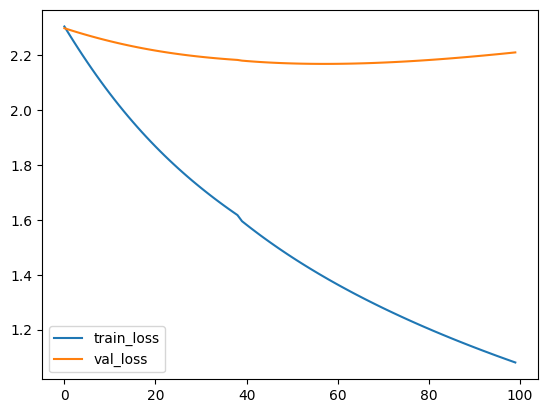

In [15]:
plt.plot(pd.read_csv("logs/debug_model_10/version_0/metrics.csv")["train_loss_epoch"].dropna().reset_index(drop=True), label="train_loss")
plt.plot(pd.read_csv("logs/debug_model_10/version_0/metrics.csv")["val_loss"].dropna().reset_index(drop=True), label="val_loss")
plt.legend()
plt.show()